In [0]:
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

--2019-01-09 10:34:15--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.108.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.108.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  85.7MB/s    in 5.0s    

2019-01-09 10:34:20 (59.1 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]



In [0]:
!unzip -qq -o "flower_data.zip"

In [0]:
!pip install Pillow==5.3.0

    100% |████████████████████████████████| 2.0MB 14.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x573de000 @  0x7f8973d9f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import PIL

In [0]:
print(PIL.PILLOW_VERSION)

5.3.0


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
dirs = {'train': train_dir, 
        'valid': valid_dir}

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

In [0]:
!gdown https://drive.google.com/uc?id=1-4f9FoHXASIDRF2BbITv29jk_1w3tN6N

Downloading...
From: https://drive.google.com/uc?id=1-4f9FoHXASIDRF2BbITv29jk_1w3tN6N
To: /content/classifier-2l.pth
493MB [00:03, 149MB/s]


In [0]:
model = models.vgg19(pretrained=True)

In [0]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
classifier = nn.Sequential(OrderedDict([
                                          ('fc1', nn.Linear(25088, 102)),
                                          ('relu', nn.ReLU()),
                                          ('output', nn.LogSoftmax(dim=1))
                                          ]))


In [0]:
for param in model.parameters():
  param.requires_grad = False

In [0]:
model.classifier = classifier

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    print(device)
    since = time.time()
    valid_loss_min = np.Inf

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
            
        loss_hash = {'train' : 0.0, 'valid': 0.0}
                
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print('')
            step_id = 0
            for inputs, labels in dataloaders[phase]:
                if step_id % 10 == 0:
                  print('{}'.format(step_id), end=", ")
                step_id = step_id+1
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                loss_hash[phase] += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # calculate average losses
            loss_hash['train'] = loss_hash['train']/len(dataloaders['train'].dataset)
            loss_hash['valid'] = loss_hash['valid']/len(dataloaders['valid'].dataset)
            
            print('')

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        # save model if validation loss has decreased
        if loss_hash['valid'] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            loss_hash['valid']))
            model.class_to_idx = image_datasets['train'].class_to_idx
            model_save_name = 'classifier-1l.pth'
            path = F"/content/gdrive/My Drive/{model_save_name}" 
            torch.save({'arch': 'vgg19',
                        'state_dict': model.state_dict(), 
                        'class_to_idx': model.class_to_idx}, 
                        path)
            valid_loss_min = loss_hash['valid']
       

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer= optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
# Number of epochs


In [0]:
eps=5

In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model.cuda()
model_ft = train_model(model, criteria, optimizer, sched, eps, 'cuda')

cuda
Epoch 0/4
----------

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 
train Loss: 4.5996 Acc: 0.0136

0, 10, 20, 
valid Loss: 4.5937 Acc: 0.0183
Validation loss decreased (inf --> 4.593687).  Saving model ...
Epoch 1/4
----------

0, 

KeyboardInterrupt: ignored

In [0]:
def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device='cuda')    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print(equals)
            print(equals.float().mean())

In [0]:
calc_accuracy(model, 'valid', True)

tensor([56, 38, 84, 13, 77, 78, 73, 71, 74, 13, 75, 95, 96,  2, 60, 49,  9,  0,
        59, 16, 97, 52, 43, 43, 88, 56, 76, 16, 55, 56, 43, 67],
       device='cuda:0')
tensor([0.8280, 0.9982, 0.9992, 0.9999, 1.0000, 0.9999, 1.0000, 1.0000, 0.9852,
        0.9218, 0.9996, 0.4911, 0.9823, 1.0000, 0.9993, 0.3258, 0.9514, 0.9172,
        0.9943, 0.9958, 0.8390, 0.9892, 0.9995, 1.0000, 0.9984, 1.0000, 0.5755,
        1.0000, 0.9976, 0.9792, 1.0000, 0.9918], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'classifier.pth')

In [0]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'vgg19':
        model = models.vgg19(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized") 
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                                          ('fc1', nn.Linear(25088, 4096)),
                                          ('relu', nn.ReLU()),
                                          ('fc3', nn.Linear(4096, 102)),
                                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [0]:
model = load_model('classifier-2l.pth')
calc_accuracy(model, 'train', True)
model

tensor([78,  1, 43, 50, 54, 40, 75, 41, 37, 87, 90, 53, 19,  8, 77, 76, 78, 85,
        90, 77, 40, 56, 20, 47, 85, 87, 83, 97, 23, 11, 93, 11],
       device='cuda:0')
tensor([0.9999, 0.8120, 0.2390, 0.1168, 1.0000, 0.9718, 1.0000, 1.0000, 0.9829,
        0.9303, 0.4556, 0.9996, 0.7497, 0.9463, 1.0000, 0.4526, 0.9971, 0.9369,
        0.9892, 0.9402, 0.4829, 0.6049, 0.9976, 0.9774, 1.0000, 0.8381, 0.9939,
        0.9201, 0.7005, 1.0000, 0.8946, 0.9993], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.7812, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.7812, device='cuda:0')
tensor(0.8750, device='c

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
# 1
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [0]:
#2
# obtain one batch of test images
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()
images.numpy()
images = images.to('cuda')
labels = labels.to('cuda')
# move model inputs to cuda, if GPU available
model.cuda()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(label_map[str (preds[idx]+1)], label_map[str (labels[idx].item()+1)]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

TypeError: ignored

In [0]:
#3
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
model.cuda()
# iterate over test data
for data, target in dataloaders['train']:
    # forward pass: compute predicted outputs by passing inputs to the model
    data = data.to('cuda')
    target = target.to('cuda')
    output = model(data)
    # calculate the batch loss
    loss = criteria(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())     # calculate test accuracy for each object class
    for i in range(17):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(dataloaders['valid'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(101):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            label_map[str(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (label_map[str(i+1)]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 3.611254

Test Accuracy of pink primrose: 92% (12/13)
Test Accuracy of hard-leaved pocket orchid: 87% (14/16)
Test Accuracy of canterbury bells: 83% (10/12)
Test Accuracy of sweet pea: 86% (26/30)
Test Accuracy of english marigold: 100% (19/19)
Test Accuracy of tiger lily: 79% (31/39)
Test Accuracy of moon orchid: 91% (41/45)
Test Accuracy of bird of paradise: 90% (20/22)
Test Accuracy of monkshood: 88% (24/27)
Test Accuracy of globe thistle: 92% (24/26)
Test Accuracy of snapdragon: 93% (15/16)
Test Accuracy of colt's foot: 100% (33/33)
Test Accuracy of king protea: 84% (28/33)
Test Accuracy of spear thistle: 79% (19/24)
Test Accuracy of yellow iris: 100% (22/22)
Test Accuracy of globe-flower: 90% (20/22)
Test Accuracy of purple coneflower: 93% (14/15)
Test Accuracy of peruvian lily: 95% (22/23)
Test Accuracy of balloon flower: 94% (37/39)
Test Accuracy of giant white arum lily: 88% (15/17)
Test Accuracy of fire lily: 100% (19/19)
Test Accuracy of pincushion flower: 92% (13/

In [0]:
from PIL import Image
image_path = 'flower_data/valid/65/image_03222.jpg'
img = Image.open(image_path)

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

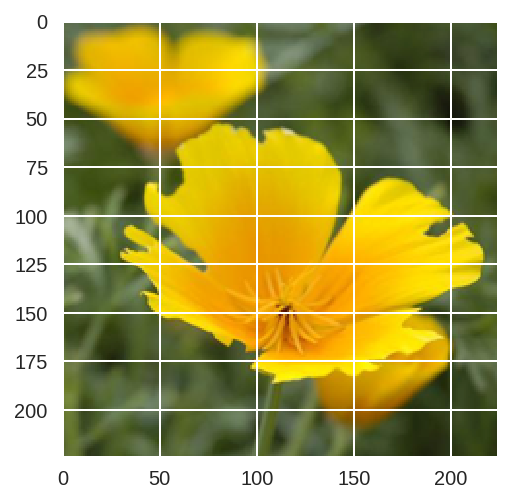

In [0]:
image_path = 'flower_data/valid/65/image_03222.jpg'
img = process_image(image_path)
imshow(img)

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
def plot_solution(image_path, model):
    # Set up plot
    model.cpu()
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = label_map[flower_num]
    # Plot flower
    img = process_image(image_path)
    
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    model.cuda()
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


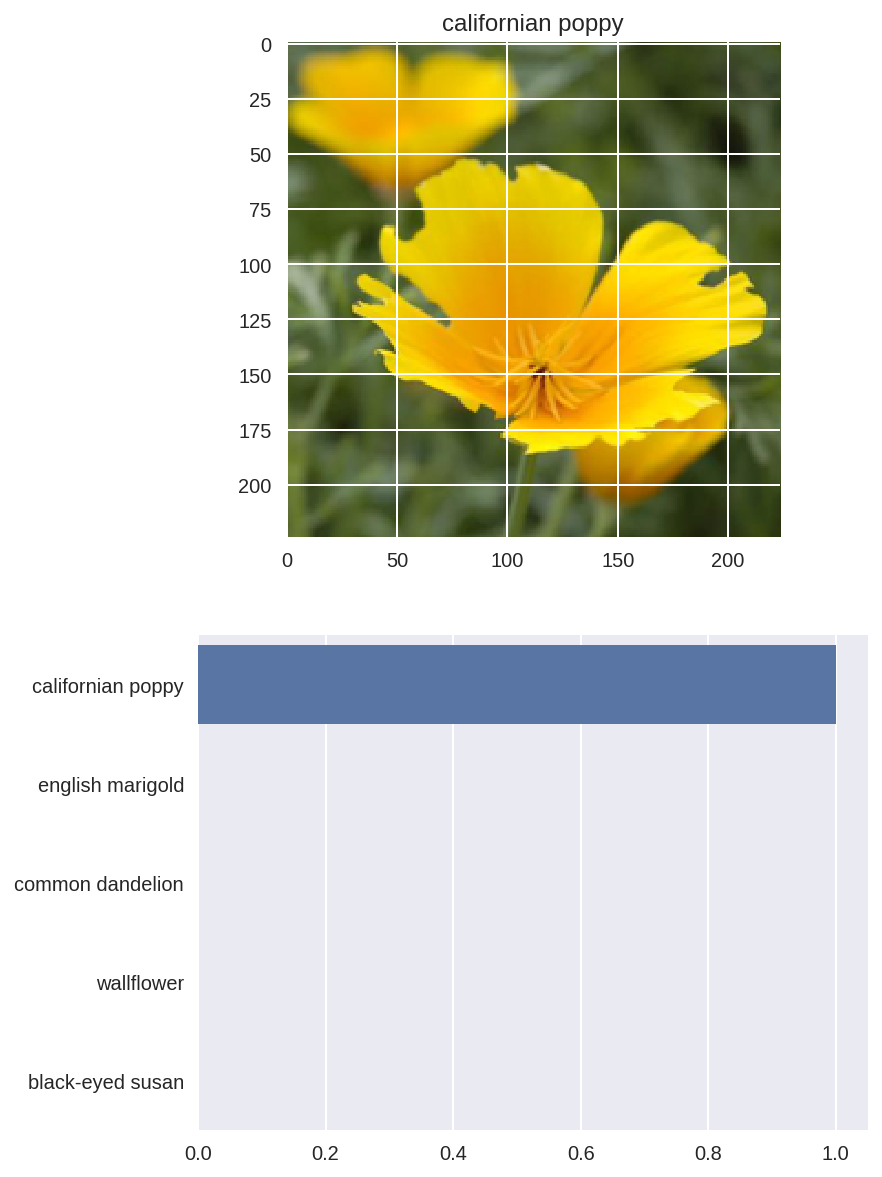

In [0]:
image_path = 'flower_data/valid/65/image_03222.jpg'
plot_solution(image_path, model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


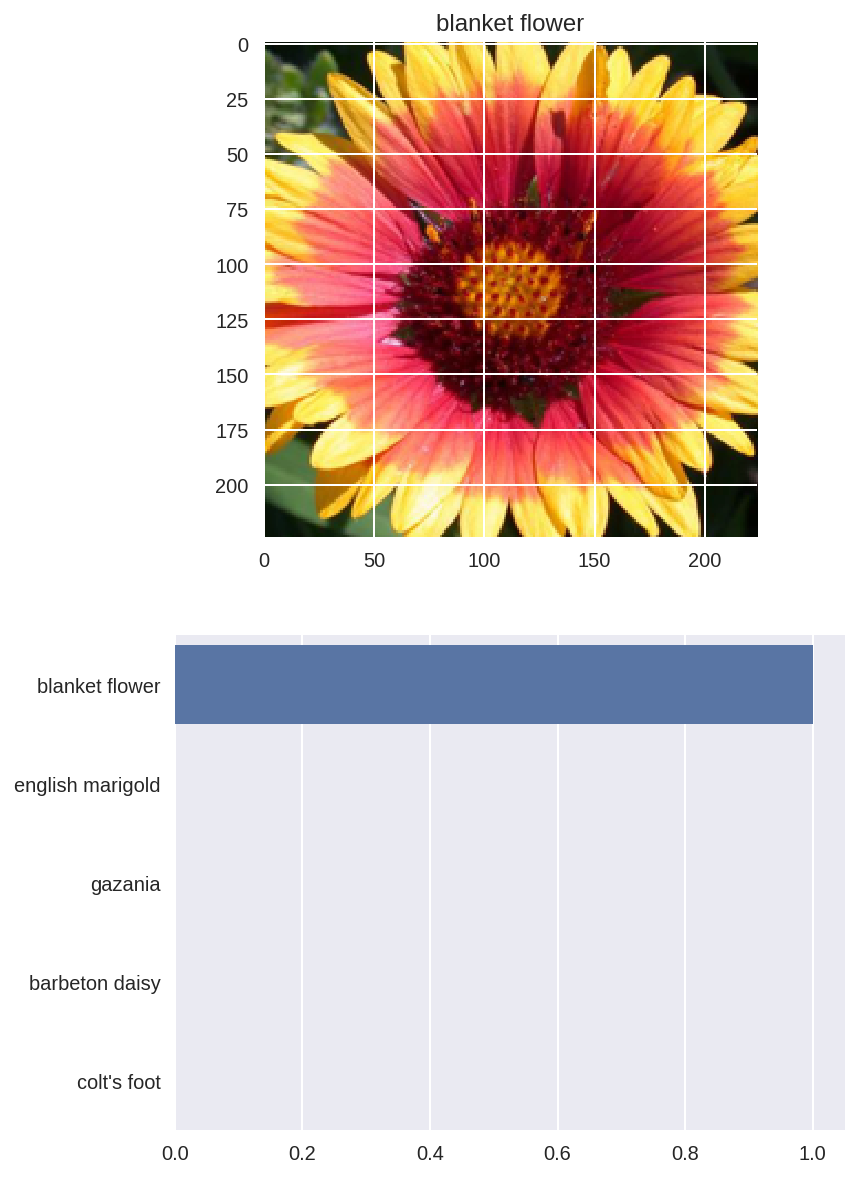

In [0]:
image_path = 'flower_data/valid/100/image_07917.jpg'
plot_solution(image_path, model)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'classifier-2l.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save({'arch': 'vgg19',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            path)

In [0]:
!gdown https://drive.google.com/uc?id=1-4f9FoHXASIDRF2BbITv29jk_1w3tN6N

Downloading...
From: https://drive.google.com/uc?id=1-4f9FoHXASIDRF2BbITv29jk_1w3tN6N
To: /content/classifier-2l.pth
493MB [00:02, 205MB/s]
